In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
import numpy as np
import scipy.io as spio
import os
from os.path import dirname, join as pjoin
from numpy import array
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from collections import Counter
import seaborn as sns
import glob
import matplotlib.ticker as ticker
from PIL import Image
import statistics 

import warnings
warnings.filterwarnings('ignore')

In [2]:
mat_path = pjoin('../../ml/NDTPhase2/data','data.mat')
mat = spio.loadmat(mat_path)
cell_data = mat['data']

0.3734241943359375 0.11313492593101104 (250, 320, 256)


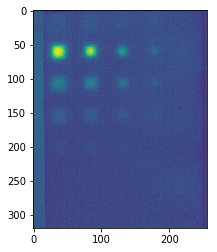

In [4]:
dataT = cell_data.T
i0 = dataT[100]
print(np.mean(i0),np.std(i0), dataT.shape)
plt.imshow(i0);

In [5]:
class Args:
    def __init__(self):
        self.cuda = True
        self.seed = 1
        self.epochs = 1
        self.lr = 0.0001
args = Args()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [6]:
def transform_fn(data):
    data = data.astype(np.float32)
    data = torch.from_numpy(data)
    return data

In [14]:
class Autoencoder_iter(nn.Module):
    def __init__(self,k1,k2,k3):
        super(Autoencoder_iter,self).__init__()     
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=k1),
            nn.ReLU(True),
            nn.Conv2d(4 ,8 ,kernel_size=k2),
            nn.ReLU(True),
            nn.Conv2d(8, 16,kernel_size=k3),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,8,kernel_size=k3),
            nn.ConvTranspose2d(8,4,kernel_size=k2),
            nn.ConvTranspose2d(4,1,kernel_size=k1),
            nn.Tanh())
    def forward(self,x):
        
        b, h, w = x.size()
        x = x.view(b, 1, h, w)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
model = Autoencoder()
def weight_reset(m):
    if isinstance(m, nn.Conv2d):
        m.reset_parameters()
model.apply(weight_reset)
if args.cuda: 
     model.cuda()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [9]:
def SNR(dataT, ):
    variance = []
    defected_sum = []
    non_defected_sum = []
    values = []
    d_sum = 0
    non_sum = 0
    img = dataT[100]
    d1 = [50,72,51,69,96,119, 97,118]
    d2 = [26,48,75,93,25,49,73,96]
    snr_ = []
    d = dataT
    for j in range(72,94):
        for k in range(102,124):
            values.append(d[j][k])
            non_sum = non_sum + d[j][k]
    non_defected_sum.append(non_sum)
    variance.append(np.var(values))
    for p in range(0,4):
        for j in range(d1[p*2],d1[p*2+1]):
            for k in range(d2[p*2],d2[p*2+1]):
                d_sum = d_sum + d[j][k]
        defected_sum.append(d_sum)
        signal = (list(set(defected_sum) - set(non_defected_sum)))
        noise = np.sqrt(variance)
        SNR = signal/(noise*((d1[p*2+1]-d1[p*2])**2))
        
        if(len(SNR)==0):
            snr_.append(0)
        else:
            snr_.append(round(max(SNR), 2))
    return snr_

In [10]:
#rewrite this optimally
def plots(img):
        all_snr = [0]*4
        fig = plt.figure(figsize=(16, 4), constrained_layout=True)
        all_fig = fig.add_gridspec(1, 4)
        img1 = all_fig[0].subgridspec(1, 1)
        img2 = all_fig[1].subgridspec(1, 1)
        img3 = all_fig[2].subgridspec(1, 1)
        img4 = all_fig[3].subgridspec(1, 1)
        ax1 = fig.add_subplot(img1[0, 0])
        ax2 = fig.add_subplot(img2[0, 0])
        ax3 = fig.add_subplot(img3[0, 0])
        ax4 = fig.add_subplot(img4[0, 0])
        img_ = img[0]
        img_ = np.reshape(img_,(320,256))
        try:
            snr_ = SNR(img_)
            ax1.set_title(snr_)
            all_snr.append(snr_)
        except:
            print('0 SNR')
            ax4.imshow(img_)
            plt.show()
            return 'snr0'
        if max(snr_) < 40000:
            img_ = np.flip(np.rot90(img_), 0)
            ax1.imshow(img_)
            img_ = img[1]
            img_ = np.reshape(img_,(320,256))
        else:
            return 'snr0'
        try:
            snr_ = SNR(img_)
            ax2.set_title(snr_)
            all_snr.append(snr_)
        except:
            print('0 SNR')
            ax4.imshow(img_)
            plt.show()
            return 'snr0'
        if max(snr_) < 40000:
            img_ = np.flip(np.rot90(img_), 0)
            ax2.imshow(img_)
            img_ = img[2]
            img_ = np.reshape(img_,(320,256))
        else:
            return 'snr0'
        try:
            snr_ = SNR(img_)
            ax3.set_title(snr_)
            all_snr.append(snr_)
        except:
            print('0 SNR')
            ax4.imshow(img_)
            plt.show()
            return 'snr0'
        if max(snr_) < 40000:
            img_ = np.flip(np.rot90(img_), 0)
            ax3.imshow(img_)
            img_ = img[3]
            img_ = np.reshape(img_,(320,256))
        else:
            return 'snr0'
        try:
            snr_ = SNR(img_)
            ax4.set_title(snr_)
            all_snr.append(snr_)
        except:
            print('0 SNR')
            ax4.imshow(img_)
            plt.show()
            return 'snr0'
        if max(snr_) < 40000:
            img_ = np.flip(np.rot90(img_), 0)
            ax4.imshow(img_)
            plt.show()
        else:
            return 'snr0'
        return all_snr
        

In [11]:
data_train = transform_fn(dataT)
train_dataset = TensorDataset(data_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [23]:
def generate_new(model_, k, count_, ep=4):
    count = count_
    for epoch in range(ep):
        count += 1
        values = []
        img = []
        optimizer = torch.optim.Adam(model_.parameters(),lr=0.001)
        total = 0
        for data_ in train_loader:
            model_.train()
            data_ = torch.FloatTensor(data_[0])
            if args.cuda:
                    data_ = data_.cuda()
            optimizer.zero_grad()
            output = model_(data_)
            loss = distance(output, data_)
            total += loss.item()
            loss.backward()
            optimizer.step()
        
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, ep, total))
        for i in range(4):
            idx = random.randint(0,249)
            model.eval()
            data_ = dataT[idx]
            data_ = data_.reshape(1, dataT[idx].shape[0], dataT[idx].shape[1])
            output = model_(transform_fn(data_).cuda())
            img.append(output.detach().cpu().numpy())
        print(count)
        sn=plots(img)
        if sn=='snr0':
                return count
        else:
            img.append(sn)
            np.save('../models/{}_{}-{}-{}.npy'.format(count,k[0],k[1],k[2]), 
                    np.array(img)) 
        return count

epoch [1/1], loss:5.8876
1


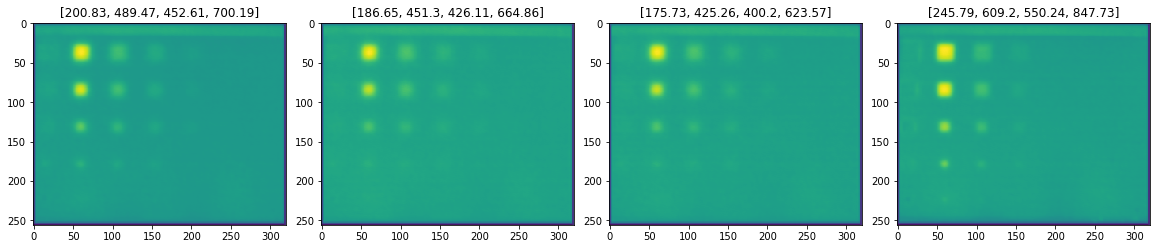

In [24]:
k = [3, 3, 3]
count = 0
model_iter = Autoencoder_iter(k1=k[0],k2=k[1],k3=k[2])
if args.cuda: 
     model_iter.cuda()
model_iter.apply(weight_reset)
count = generate_new(model_iter, k, count_=count, ep=1)